#  Biases in Word2Vec?

_Notebook by Emma Gerritse and Arjen P. de Vries_

## Introduction

_Word Embeddings_ produced by algorithms like Google's Word2Vec (W2V) have quickly become the de facto method to include textual data into analyses, partially because they conveniently summarize varying length character sequences as a fixed series of numbers that can easily serve as input to machine learning approaches, especially those using neural networks.

The paper [Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings](https://arxiv.org/abs/1607.06520) (Bolukbasi et al., 2016) raises the concern that Word Embeddings might exhibit female/male gender stereotypes to a disturbing extent. Is this really true, and, if so, how does that impact intelligent processing of texts using computers?

This notebook briefly reviews Word Embeddings and their role in understanding semantic relations between words. It reproduces the results of the Bolukbasi paper, explores how we may need to be less concerned than the authors of the manuscript have suggested; but, at the same time making clear how difficult it is to avoid or even diagnose bias in text representations learned from large amounts of human information.

## Word Embeddings

Already in the 1950s researchers experimented with different ways to represent text as vectors in high-dimensional spaces. In recent years, the representation produced by Word2Vec [(Mikolov, 2013)](https://arxiv.org/abs/1301.3781) has been a successful component in a huge number of intelligent text processing systems using (deep) neural networks; as an example of how well text can be captured by Word Embeddings produced by W2V and variations like Glove, have some fun with the [Talk to Transformer](https://talktotransformer.com/) text generation demo!

The intuition underlying Word Embeddings is that you feed the computer a huge number of sentences, real text, and give it the objective to predict word occurrence in every sentence using just the information contained in the rest of the sentence, while representing the word as a point in a high dimensional space. _Exactly_ how W2V embeds text in continuous high dimensions is perhaps best explained by Xin Rong's [_word2vec Parameter Learning Explained_](https://arxiv.org/abs/1411.2738) (Rong, 2019). WEVI, the online [wevi: word embedding visual inspector](https://ronxin.github.io/wevi/) is particularly helpful in gaining insight. 

Today, we do not need that level of understanding though - it is enough to know that every word that we encounter will be converted into a series of 300 numbers, in such a way, that a neural network that reads these numbers as input to predict its occurrence (when it is held-out from the data) from its context makes the lowest number of mistakes. We say that the 300-d vector represents the word and its context, and use this vector as a more concise representation than the original texts that it was derived from.

### Pre-trained Word Embeddings

The method to create word embeddings ideally uses large amounts of text data as input - similar to the text that the algorithm should work with. In practice, many researchers (including those from the Bolukbasi paper that warns against bias in Word Embeddings) use _pre-trained_ word embeddings, and a popular choice is the dataset distributed by the authors of the W2V paper who used a large amount of articles from Google News.

We use these [pre-trained Google News Word Embeddings](https://code.google.com/archive/p/word2vec/), provided by Google as research data with their [2013 NIPS paper](https://arxiv.org/abs/1310.4546).

Load the W2V vectors in the `gensim` Python library:

In [82]:
import gensim

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
# Note: loading the embeddings takes around 10 minutes, and we suggest a minimum of 8 GB of ram.
#model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

# Using Memory Mapped files leads to significantly better performance, so save and reload:
#model.save('GN-vectors.bin')

# Load the wordvectors using memory mapped files:
model = gensim.models.KeyedVectors.load('GN-vectors.bin', mmap='r')

### Word Vector Scatter Plots

The pre-trained Word Embeddings are 300-dimensional vectors, not easily interpreted by humans. Consider for example the first 16 values for the word "China": 

In [83]:
# First 16 dimensions of the word vector for China (from 300)
model.get_vector("China")[1:16]

memmap([ 0.13574219,  0.10888672,  0.08300781, -0.12792969, -0.22753906,
         0.15136719, -0.0456543 , -0.06542969,  0.03442383, -0.140625  ,
        -0.02355957,  0.24609375, -0.27148438, -0.1875    , -0.11865234],
       dtype=float32)

_Isn't it surprising that computers understand language better by transforming words into these huge vectors?!_

To understand how words are situated in the embedding space and inspect how word vectors of different words relate to each other, researchers usually _project_ sets of word vectors onto a 2-dimensional space that we can create figures of; a common method to achieve that is known as Principal Components Analysis (PCA), and the resulting plots are referred to as word vector scatter plots.

The next block of code defines a function `words_pca` to transform word vectors to coordinate pairs (no need to understand the details):

In [84]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
#import umap
import matplotlib.pyplot as plt

# PCA projection of the word embeddings of a given list of words
#
def words_pca(word_list, transform = 'pca'):
    # Looking up the vectors per word
    bias_vectors = [model[word] for word in word_list]
    # scaling the wordvectors
    bias_vectors = StandardScaler().fit_transform(bias_vectors)
    # applying PCA with 2 components
    if transform == 'pca':
        pca = PCA(n_components=2)
        bias_pca = pca.fit_transform(bias_vectors)
    elif transform == 'tsne':
        bias_pca = TSNE(n_components=2).fit_transform(bias_vectors)
    else:
#       bias_pca = umap.UMAP().fit_transform(bias_vectors)
        bias_pca = []
    return bias_pca
    

The Google NIPS paper argues that Word Embeddings _learn_ to capture semantic relationships between words, a claim they illustrate with an example how countries and capitals are situated in the embedding space in a very specific way, such that you can infer the capital for new countries or vice versa, applying simple vector arithmetic.

Let's take a look. First, create a vector scatter plot of countries and capitals:

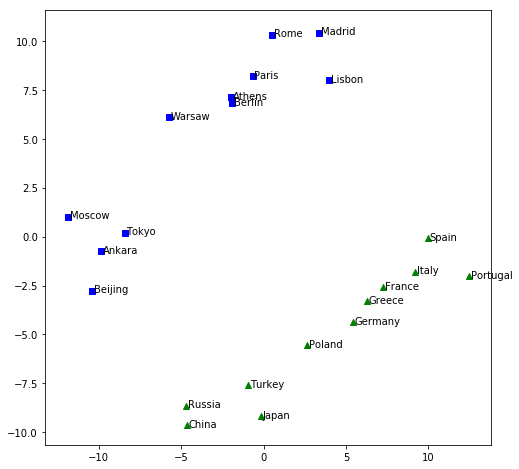

In [88]:
# Countries and Capitals from W2V paper:
countries = ['China', 'Russia', 'Japan', 'Turkey', 'Poland', 'Germany', 'France', 'Italy', 'Greece', 'Spain', 'Portugal']
capitals =  ['Beijing', 'Moscow', 'Tokyo', 'Ankara', 'Warsaw', 'Berlin', 'Paris', 'Rome', 'Athens', 'Madrid', 'Lisbon']

# Projecting on 2D using PCA
words = countries + capitals
ccproj = words_pca(words, transform = 'pca')

plt.figure(figsize=(8,8))
# Plotting the PCA with words
for i,word in enumerate(words):
    x = ccproj[i,0]
    y = ccproj[i,1]
    if word in countries:
        plt.scatter(x, y, marker='^', c='g')
    elif word in capitals:
        plt.scatter(x, y, marker='s', c='b')
    plt.text(x+0.1, y-0.1, word, fontsize=10)
        
plt.show()


You can see that the countries and capitals cluster together, and, you may also have noticed the property that the Google researchers called _compositionality_ of the embeddings: pairs of country and capital seem to have very similar translation vectors. 

If that is indeed the case, we might take one pair of country and capital, compute its translation vector, and apply that to other countries or capitals! Let's check with a few examples:

In [89]:
# Spain - Madrid + Rome
model.most_similar(positive=['Spain','Rome'], negative = ['Madrid'], topn = 1)

[('Italy', 0.7004686594009399)]

In [90]:
# Beijing - China + Japan
model.most_similar(positive=['Beijing','Japan'], negative = ['China'], topn = 1)

[('Tokyo', 0.8115593194961548)]

## Biased Word Vectors?

The Bolukbasi paper's claim of inherent bias in word vectors is based on the exact same relation between words, but they look at the relation between the words _he_ and _she_ in relation to the word of interest.

As motivating example that made it to the paper's title, they look at the word vectors close to the result of `computer_programmer - he + she`; i.e., they consider the result of translation in the embedding space along the direction and distance given by `she - he`, with the `computer_programmer` word vector as starting point, and, likewise, where you end up starting from `beautician` moving in the opposite direction.

In other words: _What is the female equivalent of `computer_programmer` and the male equivalent of `beautician`?_

In [93]:
print("Most similar to computer_programmer - he + she: \n",
      model.most_similar(positive = ['computer_programmer', 'she'], negative = ['he'], topn = 5), "\n")
print("Most similar to beautician - she + he: \n", model.most_similar(positive = ['beautician', 'he'], negative = ['she'], topn = 5))


Most similar to computer_programmer - he + she: 
 [('homemaker', 0.5700256824493408), ('housewife', 0.5342153906822205), ('businesswoman', 0.5196776390075684), ('saleswoman', 0.5168929696083069), ('graphic_designer', 0.5157608985900879)] 

Most similar to beautician - she + he: 
 [('barber', 0.6375421285629272), ('handyman', 0.5406479835510254), ('carpenter', 0.5381854772567749), ('mechanic', 0.526857852935791), ('electrician', 0.5152750015258789)]


We can indeed confirm their finding that, considering the W2V word embeddings derived from Google News, the female equivalent of _computer programmer_ is _homemaker_ or _housewife_! Quite a worrisome stereotype, and one that we computer scientists definitely do __not__ want to reinforce in supposedly "intelligent" text processing systems.

### Looking in more detail

We should not jump to conclusions based on a single example, and consider the problem from a wider perspective.

First, what happens if we take `programmer` instead of `computer_programmer`?

In [94]:
print("Most similar to programmer - he + she: \n", model.most_similar(positive = ['programmer', 'she'], negative = ['he'], topn = 5))


Most similar to programmer - he + she: 
 [('programmers', 0.5277910232543945), ('coder', 0.5032480955123901), ('Programmer', 0.5006575584411621), ('graphic_designer', 0.48125559091567993), ('librarian', 0.4702720642089844)]


Replacing the more specific term "computer programmer" by "programmer" suggests no gender bias at all, although we are using the exact same technique as above.

We suspect that the number of occurrences of the term for which we take an embedding might have a large effect on the outcomes. Unfortunately, we do not know much about the corpus that provides the pre-trained Word Embeddings, other than that they are derived from a large corpus of Google News data, in 2013. 

_The release of word vectors as open data does not contain sufficient information to understand in full detail what is going on!_ To evaluate the relative frequency of terms, we can make an estimate from similar sources; e.g., the public information from [Google trends](https://trends.google.com/trends/explore?geo=US&q=computer%20programmer,programmer) might be derived from textual data with characteristics similar to the Google News sources - but we cannot be certain.

Next, let us investigate whether these analogies hold both ways. If _computer programmer - he + she = homemaker_, does the reverse also hold? What is the result of _homemaker - she + he_ ? 

In [95]:
print("Most similar to homemaker - she + he: \n", model.most_similar(positive = ['homemaker', 'he'], negative = ['she'], topn = 5))


Most similar to homemaker - she + he: 
 [('carpenter', 0.5112387537956238), ('tinkerer', 0.47657936811447144), ('machinist', 0.47604191303253174), ('mechanical_engineer', 0.4732445478439331), ('lifelong_resident', 0.4710805118083954)]


The result may still be considered stereotypical, but the translation ends at different professions than we started from.

To investigate further, we define a new function `analogy_convergence` to alternate in both directions until we get the same result in both directions:

In [96]:
def analogy_convergence(biassed_word, fromword = 'he', toword = 'she', N = 10):
    firstfrom = fromword
    firstto = toword
    biassed_from = biassed_word
    biassed_to = ""
    for i in range(N):
        analogy = model.most_similar(positive = [biassed_from, toword], negative = [fromword], topn = 1)[0][0]
        print(biassed_from, " - ", fromword, " + ", toword, " = ", analogy)
        if analogy == biassed_to:
            break
        else:
            biassed_to = biassed_from
            biassed_from = analogy
            if i%2 == 0:
                fromword = firstto
                toword = firstfrom
            else:
                fromword = firstfrom
                toword = firstto
    if i == N:
        print("Convergence not reached within ", N, " steps")
        

In [97]:
analogy_convergence('computer_programmer', 'he', 'she')

computer_programmer  -  he  +  she  =  homemaker
homemaker  -  she  +  he  =  carpenter
carpenter  -  he  +  she  =  seamstress
seamstress  -  she  +  he  =  carpenter


In [98]:
analogy_convergence('pizzas', 'he', 'she')

pizzas  -  he  +  she  =  cupcakes
cupcakes  -  she  +  he  =  waffles
waffles  -  he  +  she  =  cupcakes


In [99]:
analogy_convergence('pizza', 'he', 'she')

pizza  -  he  +  she  =  Domino_pizza
Domino_pizza  -  she  +  he  =  pizza


The results are still surprisingly accurate, but the gender bias seems much less of a problem - the stable pairs we identified are not problematic, at first sight. We may even start to worry whether the authors cherry-picked a few rather specific examples to support their case?

### Similarities between words according to their embeddings

If we look beyond the analogies (the translated word vectors), it makes a lot of sense to look at the similarities between the word vectors for the words that we consider. We can infer word similarity from the distance between word vectors, using cosine similarity to be more robust against noise in the vector representations:

In [102]:
from scipy import spatial

def word_sim(word1, word2):
    return round(1-spatial.distance.cosine(model[word1], model[word2]),2)

In [103]:
print("Distance between 'he' and 'computer_programmer':", word_sim('he', 'computer_programmer'))
print("Distance between 'she' and 'computer_programmer':",word_sim('she', 'computer_programmer'))
print("Distance between 'he' and 'homemaker':", word_sim('he', 'homemaker'))
print("Distance between 'she' and 'homemaker':",word_sim('she', 'homemaker'))
print("Distance between 'he' and 'she':", word_sim('he', 'she'))

Distance between 'he' and 'computer_programmer': 0.18
Distance between 'she' and 'computer_programmer': 0.19
Distance between 'he' and 'homemaker': 0.13
Distance between 'she' and 'homemaker': 0.4
Distance between 'he' and 'she': 0.61


Surprisingly, the word vector for 'she' is closer to 'computer_programmer' according to their embeddings than the word vector for 'he'!

### Gender bias depicted in word vector scatter plots

Bolukbasi et al. (2016) list the following words as most biased in gender.

In [107]:
super_gendered = ['king', 'queen', 'brother', 'sister', 'mother', 'father',
                  'she', 'woman', 'he', 'man', 'grandpa', 'grandma', 'boy', 'girl',
                 'her', 'his', 'daughter', 'son', 'Mary', 'John']

In [129]:
# setting the plotsize
plt.rcParams['figure.figsize'] = [12, 12]

We can plot the word vectors to inspect visually how gendered word embeddings are. 

Note that you can optionally add a list of super gendered words by uncommenting  the line after 'optional, add gendered words'. Doing so would push 'gender' as the principal component, and is likely to result in more pronounced word vector scatter plots. 

First, look at the words that the authors described as being biased:

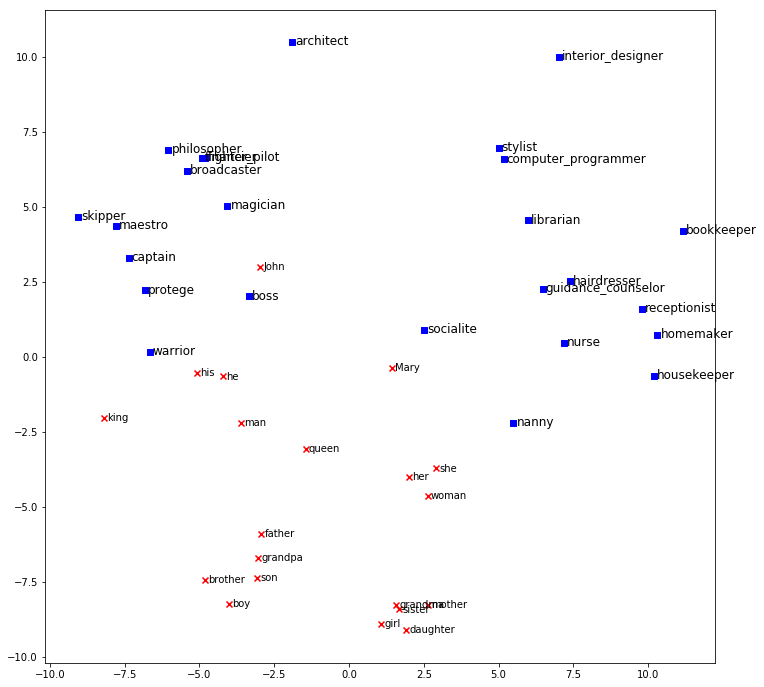

In [130]:
# list of biased words, without the genderwords:
bias_words = ['homemaker', 'nurse', 'receptionist', 'librarian', 
              'socialite', 'hairdresser', 'nanny', 'bookkeeper', 'stylist','housekeeper', 
              'interior_designer', 'guidance_counselor',
              'maestro', 'skipper', 'protege', 'philosopher', 'captain', 
              'architect','financier', 'warrior', 'broadcaster',
              'magician', 'fighter_pilot', 'boss', 'computer_programmer']

# Optional: add gendered words:
extra_gendered_words = []
#extra_gendered_words = ['ballerina','soldier','fireman','princess']

# Calculating the bias
# Options for dimensionality reduction: pca, tsne and umap
bw = bias_words + super_gendered + extra_gendered_words
bias_pca = words_pca(bw, transform = 'pca')

# Plotting the PCA with words
plt.figure

for i,word in enumerate(bw):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    if word in bias_words:
        plt.scatter(x, y, marker='s', color='blue')
        plt.text(x+0.1, y-0.1, word, fontsize=12)
    elif word in super_gendered:
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+0.1, y-0.1, word, fontsize=10)


The plot suggests the genders on the axis from left to right, but if we then look at the biased words, it seems more sensible to conclude that `computer_programmer` would be a female word rather than a male one. 

Instead of looking into especially biased words, we can also plot a much more generic [list of professions](https://www.vocabulary.cl/Basic/Professions.htm) taken from the web.

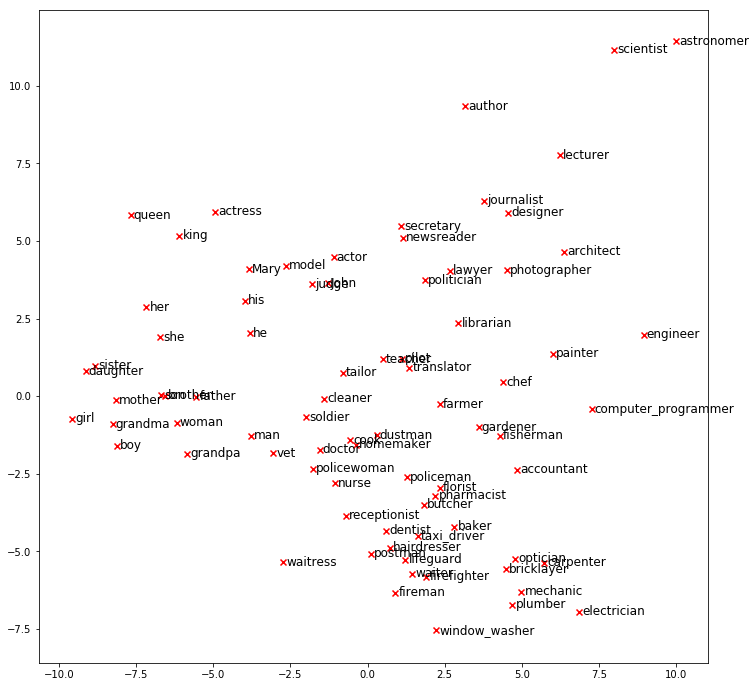

In [133]:
# List of random professions I got online, with some extra gender words
bias_words = ['accountant', 'actor', 'actress', 'architect', 'astronomer', 'author', 'baker', 'bricklayer', 
              'butcher', 'carpenter', 'chef', 'cook', 'cleaner', 'dentist', 'designer',
             'doctor', 'dustman', 'electrician', 'engineer',
             'farmer', 'fireman', 'firefighter', 'fisherman', 'florist', 'gardener', 'hairdresser',
             'journalist', 'judge', 'lawyer', 'lecturer', 'librarian', 'lifeguard', 'mechanic',
             'model', 'newsreader', 'nurse', 'optician', 'painter', 'pharmacist', 'photographer',
             'pilot', 'plumber', 'politician', 'policeman', 'policewoman', 'postman', 
             'receptionist', 'scientist', 'secretary', 'soldier', 'tailor', 'taxi_driver',
             'teacher', 'translator', 'vet', 'waiter', 'waitress',
             'window_washer', 'computer_programmer', 'homemaker']

# Optional: add gendered words:
bias_words = bias_words + super_gendered

# Calculating the bias
bias_pca = words_pca(bias_words, transform = 'pca')

# Plotting the PCA with words

for i,word in enumerate(bias_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.1, y-0.1, word, fontsize=12)
plt.show()

Here, _computer programmer_ seems closer to _engineer_ and _fisherman_, which could mean many things but a clear bias does not jump to mind.

## Conclusion

Are Word Embeddings biased, and do the perpetuate outdated stereotypes and thereby potentially harm society?

The findings depend strongly on how you interpret the word vectors and their relationships, and while the analogies constructed with vector arithmetic _do_ suggest worrisome results, reconsidering the same data using different lenses sketches a far less problematic image.

Perhaps the best lesson to take home is that computers do not yet _really_ understand language, so we have to be careful in applying this technology, never taking for granted that glitches in the input data will affect the output (as many say, garbage in, garbage out). The potential biases in textual data are far from understood, and further research remains necessary.

In [132]:
# In case you want to add a new list of words
def check_in_word2vec(wordlist):
    checked_list = []
    for word in wordlist:
        if word in model.vocab:
            checked_list.append(word)
    return checked_list